### GW tutorial 3: Generation of data and matched filtering, 09-02-2026

Author: Melissa Lopez

Email: m.lopez@uu.nl

In [36]:
!pip install pycbc
%matplotlib inline
from pycbc.catalog import Merger
import pycbc.psd, pycbc.noise
import pylab
import matplotlib.pyplot as plt
import numpy as np
from pycbc.waveform import get_td_waveform
from pycbc.detector import Detector
import random

Previously, we have plotted the PSD of different detectors. Some PSDs are from previous runs (O3), while some others are the design sensitivity of future detectors.

The PSD characterizes the noise of the detector, so we can generate detector noise accordingly.

**Exercise 1:** Load the `aligo_O4high.txt` PSD to [generate](https://pycbc.org/pycbc/latest/html/pycbc.noise.html#pycbc.noise.gaussian.noise_from_psd) some Gaussian data.

_Hint:_ Minimum frequency is 10 Hz, sampling rate 4096 Hz and we want 20s of duration

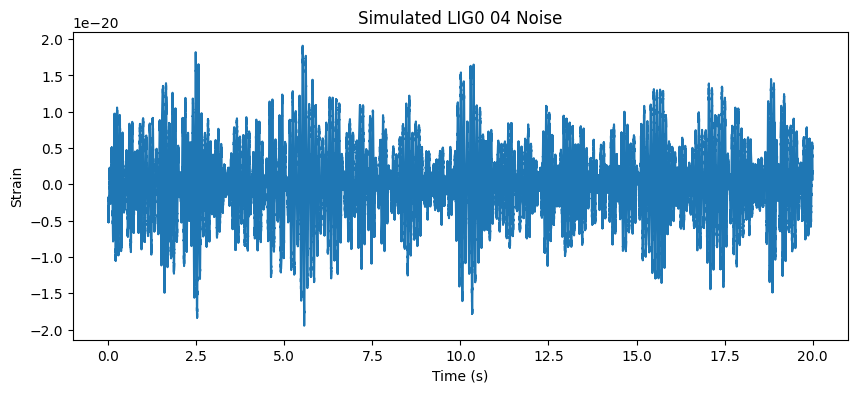

In [37]:

import matplotlib.pyplot as plt
import pycbc.psd
import pycbc.noise
from google.colab import files


flow =10.21659
sample_rate = 4096
duration = 20.0
delta_t = 1.0 / sample_rate #
delta_f = 1.0 / duration #

n_samples= int(duration * sample_rate) # this is just the number of samples that we will need taking: 4096 samples per second for 20 seconds
flen = int(n_samples/2) + 1  # this is the humber of frequency bins needed so the PSD.to match the data in frequency space.


path='/content/'
# we load the data from the psd file
psd = pycbc.psd.read.from_txt(path + 'aligo_O4high.txt', flen, delta_f, flow, is_asd_file=True)


# then we generate the noise for the psd
noise = pycbc.noise.gaussian.noise_from_psd(n_samples, delta_t, psd, seed=42)

# and finally we plot the noise
plt. figure(figsize=(10, 4))
plt. plot(noise.sample_times, noise)
plt. xlabel("Time (s)")
plt. ylabel("Strain")
plt. title("Simulated LIG0 04 Noise")
plt. show()










As you can see. the generated noise is "coloured" according to the detector noise. Now, we would like to add a simulated gravitational wave signal in our detector noise.

**Exercise 2:** Using [this function](https://pycbc.org/pycbc/latest/html/pycbc.waveform.html#pycbc.waveform.waveform.get_td_waveform) to generate waveforms in time domain, provide the plus and cross polarization of a binary black hole merger of $m_{1} = m_{2} = 50$ at 2000 Mpc. Use the waveform approximant "IMRPhenomD". How does the waveform amplitude compare to the detector noise?

The waveform comes from the source, but it needs to be projected in the detector. [Project](https://pycbc.org/pycbc/latest/html/pycbc.detector.html#pycbc.detector.ground.Detector.project_wave) the waveform on LIGO Livingston (L1) at random sky-location and polarization. You can specify your detector with [this](https://pycbc.org/pycbc/latest/html/pycbc.detector.html#pycbc.detector.ground.Detector) function. How does the waveform change because of this projection?

_Hint:_ Right ascension range is $[0, 2\pi]$, declination is $[-2\pi, 2\pi]$ and polarization is $[0, 2\pi]$.

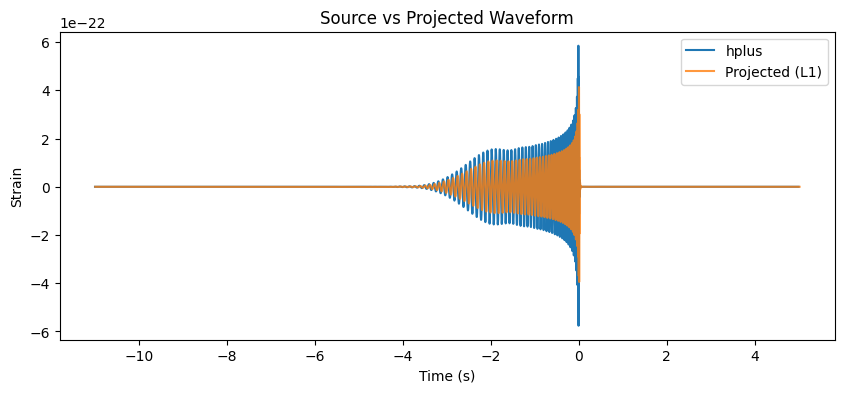

In [38]:
# we input the data of the merger into the function to get the plus and cross polarizations
hplus, hcross = pycbc.waveform.waveform.get_td_waveform(approximant="IMRPhenomD", mass1=50, mass2=50, distance=2000, f_lower=flow, delta_t=delta_t)

# we specify the detector to be L1
det = pycbc.detector.ground.Detector("L1")

# with this we genrate a random sky location by generating a random Right Ascension between 0 and 2π,
# Declination between -π/2 to π/2 (I think -2π to 2π was a typo) and Polarization angle between 0 and 2π
ra  = random.uniform(0, 2*np.pi)
dec = random.uniform(-np.pi/2, np.pi/2)
pol = random.uniform(0, 2*np.pi)

# now we project the waveform we created from the merger to the detector L1 to the randomly generated location in the sky
# this returns the strain of the waveform as measured by the detector
ht = det.project_wave(hplus, hcross, ra, dec, pol, method='lal')

# and finally we plot both our waveform and the projected waveform as seen by L1
plt.figure(figsize=(10, 4))
plt.plot(hplus.sample_times, hplus, label="hplus")
plt.plot(ht.sample_times, ht, label="Projected (L1)", alpha=0.8)
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.title("Source vs Projected Waveform")
plt.show()
# We observe that the waveform amplitude is much smaller than the detector noise,
# differing by about two orders of magnitude when comparing their peak values.
# This explains why the signal cannot be clearly identified in the raw time-domain data.
# We also notice that the signal amplitude decreases when it is projected onto L1.
# This is likely due to the mixing of different polarizations and depends strongly
# on the source’s position in the sky. Running the simulation multiple times shows
# that the amplitude can vary, sometimes increasing or decreasing, but it never
# exceeds the amplitude of the original unprojected waveform.


**Exercise 2:** From before our detector noise is 20s long. Add the GW into noise after 5s. We also need to get the first 4s to estimate the PSD in the next excercise. Make an overlaid plot with the total data, the portion of data where the GW is added and the data needed to estimate the PSD.

_Bonus:_ Can you also plot the GW signal?


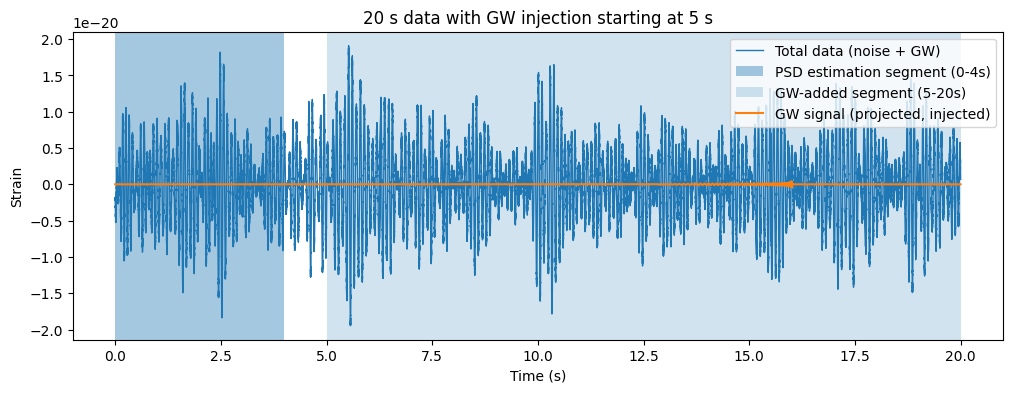

In [39]:
gw_start_time = 5.0  # s

# we start by creating a gw-only timeseries on the same time axis as the noise
gw_only = noise.copy()
gw_only[:] = 0.0

# now we convert "start at 5s" into a sample index
i0 = int(gw_start_time / delta_t)

# and add as much of the projected waveform as fits in the remaining time
n_to_add = min(len(ht), len(gw_only) - i0)
gw_only[i0:i0+n_to_add] = ht[:n_to_add]

# the otal data will be noise + gw
data = noise + gw_only

psd_segment = data.time_slice(0, 4) # first 4s of noise-only for the PSD later
gw_added_segment = data.time_slice(5, 20) # where we added the gw from 5s onward

# we now plot everything
fig, ax = plt.subplots(figsize=(12,4))

# this is the total noise plus gw
ax.plot(data.sample_times, data, label="Total data (noise + GW)", lw=1)

# this is the noise-only segment for the PSD
ax.axvspan(0, 4, alpha=0.4, label="PSD estimation segment (0-4s)")

# this is the segment where we added the gw signal
ax.axvspan(5, 20, alpha=0.2, label="GW-added segment (5-20s)")

# and this is the bonus of plotting the gw-only on top of the data
ax.plot(gw_only.sample_times, gw_only, label="GW signal (projected, injected)", lw=1.5)

ax.set_xlabel("Time (s)")
ax.set_ylabel("Strain")
ax.set_title("20 s data with GW injection starting at 5 s")
ax.legend(loc="upper right")
plt.show()

**Exercise 3:** In a proper search we do not really have the PSD handy. We want to estimate the PSD with Welch's method (see [here](https://ccrma.stanford.edu/~jos/sasp/Welch_s_Method.html) for details), but we want to use the 4s of the beginning where the GW is not present using [this function](https://pycbc.org/pycbc/latest/html/pycbc.psd.html#pycbc.psd.estimate.welch). Plot the estimated PSD. Note that before we used a dummy whitening, and this one is a bit better.

What is the $\Delta_f$ of the estimated PSD? What is $\Delta_f$ of the data we want to whiten to see the GW signal?

_Hint:_ `seg_stride (int)` is usually half of `seg_len`.


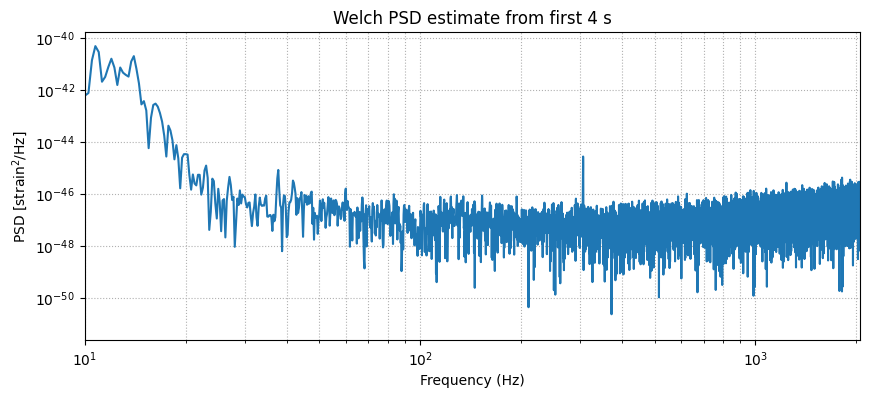

Δf (estimated PSD): 0.25 Hz
Δf (20s data): 0.05 Hz


In [40]:
 #we now estimate the PSD using Welch's method since in real life we don't have the PSD magically at our disposal
seg_len = int(sample_rate * 4) # 4s worth of samples
seg_stride = seg_len // 2 # integer dvision of seg_len by 2

psd_est = pycbc.psd.estimate.welch(psd_segment, seg_len, seg_stride)

# and we now plot it
plt.figure(figsize=(10,4))
plt.loglog(psd_est.sample_frequencies, psd_est)
plt.xlim(10, sample_rate/2)
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD [strain$^2$/Hz]")
plt.title("Welch PSD estimate from first 4 s")
plt.grid(True, which="both", ls=":")
plt.show()

# and we print delta_f values
print("Δf (estimated PSD):", psd_est.delta_f, "Hz")
print("Δf (20s data):", data.delta_f, "Hz")
#We get Δf (estimated PSD): 0.25 Hz and Δf (20s data): 0.05 Hz, this is because Δf
# is defined as 1/duration so we need to interpolate the PSD to match the data


Now that we have the PSD we need to interpolate it to match our data and then limit the filter length of 1 / PSD. After this, we can directly use this PSD to filter the data. Since the data has been highpassed above 12 Hz, and will have low values below this we need to informat the function to not include frequencies below this frequency.

**Exercise 4:** Use the functions [interpolate](https://pycbc.org/pycbc/latest/html/pycbc.psd.html#pycbc.psd.estimate.interpolate) and [inverse_spectrum_truncation](https://pycbc.org/pycbc/latest/html/pycbc.psd.html#pycbc.psd.estimate.inverse_spectrum_truncation) to achieve a proper formatting of the PSD.

_Hint:_ `max_filter_len (int)` is $4 \times$ sampling_rate. Note that the original PSD has a minimum frequency of 12Hz.

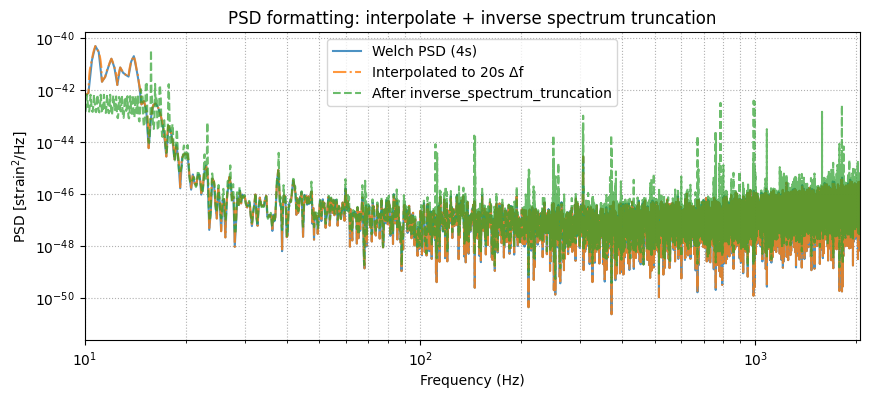

Δf(data) = 0.05 Hz
Δf(psd_fmt) = 0.05 Hz
flen(data) = 40961
flen(psd_fmt) = 40961
low_frequency_cutoff = 12.0 Hz
max_filter_len = 16384
samples = 4.0 s


In [41]:
f_low_cut = 12.0
max_filter_len = int(4 * sample_rate)

# we need to match the PSD frequency resolution (delta_f) to the data
data_fs = data.to_frequencyseries() # we first need to convert the data to a frequency series
flen = len(data_fs)
delta_f_data = data_fs.delta_f  #0.05 Hz for 20s data

# we interpolate the PSD to match the data
psd_int = pycbc.psd.interpolate(psd_est, delta_f_data)

# now we make PSD length match the data frequency series length (flen)
if len(psd_int) < flen:
    psd_int = psd_int.append_zeros(flen - len(psd_int))
else:
    psd_int = psd_int[:flen]

# and finally we apply inverse_spectrum_truncation to limit the length of 1/PSD
psd_fmt = pycbc.psd.inverse_spectrum_truncation(psd_int, max_filter_len=max_filter_len, low_frequency_cutoff=f_low_cut)


# we finally plot them and print the values to check they match what we need
plt.figure(figsize=(10,4))

plt.loglog(psd_est.sample_frequencies, psd_est, label="Welch PSD (4s)", alpha=0.8, linestyle="-")

plt.loglog(psd_int.sample_frequencies, psd_int, label="Interpolated to 20s Δf", alpha=0.8, linestyle="-.")

plt.loglog(psd_fmt.sample_frequencies, psd_fmt, label="After inverse_spectrum_truncation", alpha=0.7, linestyle="--")

plt.xlim(10, sample_rate/2)
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD [strain$^2$/Hz]")
plt.title("PSD formatting: interpolate + inverse spectrum truncation")
plt.grid(True, which="both", ls=":")
plt.legend()
plt.show()

print("Δf(data) =", delta_f_data, "Hz")
print("Δf(psd_fmt) =", psd_fmt.delta_f, "Hz")
print("flen(data) =", flen)
print( "flen(psd_fmt) =", len(psd_fmt))
print("low_frequency_cutoff =", f_low_cut, "Hz")
print("max_filter_len =", max_filter_len)
print("samples =", max_filter_len/sample_rate, "s")


Now that the PSD is ready, we can whiten the data. Before we used a PyCBC function, but mathematically this is defined as

\begin{equation}
\tilde{d_w}(f) = \tilde{d}(f)/S_{n}^{-1/2}(f)
\end{equation}
where $\tilde{d}$ and $\tilde{d_w}(f)$ are the Fourier transform of the coloured data and whitened data, respectively.

**Exercise 5:** Whiten the data using the interpolated PSD. Crop 5s at the beginning and the end to avoid border effects (_aliasing_) and bandpass it as in the previous exercise. Can you see the GW signal?

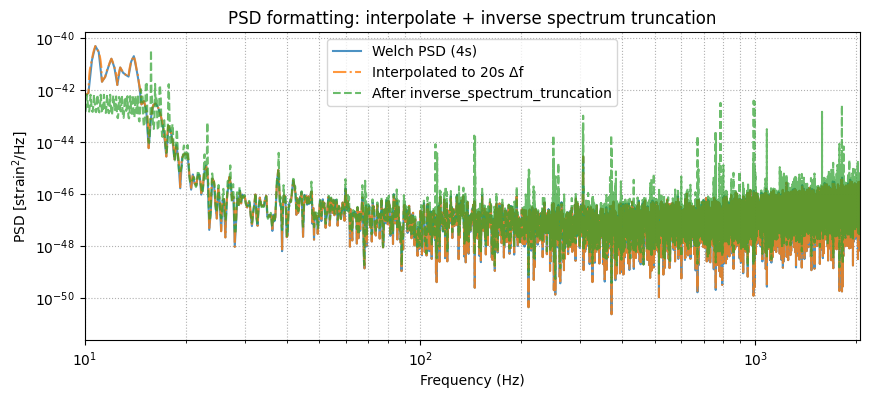

Δf(data) = 0.05 Hz
Δf(psd_fmt) = 0.05 Hz
flen(data) = 40961
flen(psd_fmt) = 40961
low_frequency_cutoff = 12.0 Hz
max_filter_len = 16384
samples = 4.0 s


In [42]:
f_low_cut = 12.0
max_filter_len = int(4 * sample_rate)

# we need to match the PSD frequency resolution (delta_f) to the data
data_fs = data.to_frequencyseries() # we first need to convert the data to a frequency series
flen = len(data_fs)
delta_f_data = data_fs.delta_f  #0.05 Hz for 20s data

# we interpolate the PSD to match the data
psd_int = pycbc.psd.interpolate(psd_est, delta_f_data)

# now we make PSD length match the data frequency series length (flen)
if len(psd_int) < flen:
    psd_int = psd_int.append_zeros(flen - len(psd_int))
else:
    psd_int = psd_int[:flen]

# and finally we apply inverse_spectrum_truncation to limit the length of 1/PSD
psd_fmt = pycbc.psd.inverse_spectrum_truncation(psd_int, max_filter_len=max_filter_len, low_frequency_cutoff=f_low_cut)


# we finally plot them and print the values to check they match what we need
plt.figure(figsize=(10,4))

plt.loglog(psd_est.sample_frequencies, psd_est, label="Welch PSD (4s)", alpha=0.8, linestyle="-")

plt.loglog(psd_int.sample_frequencies, psd_int, label="Interpolated to 20s Δf", alpha=0.8, linestyle="-.")

plt.loglog(psd_fmt.sample_frequencies, psd_fmt, label="After inverse_spectrum_truncation", alpha=0.7, linestyle="--")

plt.xlim(10, sample_rate/2)
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD [strain$^2$/Hz]")
plt.title("PSD formatting: interpolate + inverse spectrum truncation")
plt.grid(True, which="both", ls=":")
plt.legend()
plt.show()

print("Δf(data) =", delta_f_data, "Hz")
print("Δf(psd_fmt) =", psd_fmt.delta_f, "Hz")
print("flen(data) =", flen)
print( "flen(psd_fmt) =", len(psd_fmt))
print("low_frequency_cutoff =", f_low_cut, "Hz")
print("max_filter_len =", max_filter_len)
print("samples =", max_filter_len/sample_rate, "s")


So far, we buried a GW signal  $h(t)$ in stationary and Gaussian noise $n(t)$ with zero mean, such that $s(t) = h(t) + n(t)$. Given the optimal filter  $K(t)$,

\begin{equation}
\label{eq:filteredsignal}
\hat{s} = \int_{-\infty}^{\infty}  K(t)s(t) dt = \int_{-\infty}^{\infty} \tilde{K}(f)^{*}\tilde{s}(f) df, \quad \text{ where }  \tilde{s}(f) = \int_{-\infty}^{\infty} s(t)e^{-2 \pi i ft}dt
\end{equation}
where $\hat{s}$ is the filtered value of $s(t)$, $^*$ represents the complex conjugate, and $\tilde{\cdot }\ $ the Fourier transform.

The detection statistic that is maximised by the optimal filter $K(t)$  will be the SNR, defined as $\rho = S/N$. $S$ is the expected value of $\hat{s}$ when $h(t) \neq 0$, while $N$ is the squared root of the noise variance when $h(t) =0$. It can be demonstrated that the optimal filter $K(t)$ is the model of the GW signal itself, known as _template_.

The fundamental modelled detection technique is called "matched filtering", since the filter function is chosen to "match" the signal we are looking for. We can write the SNR between an unknown time series $s(t)$ and the template $h_{m}$ as

\begin{equation}
\label{eq:wienerscalar}
\rho =  4 \text{Re} \int_{0}^{\infty} \frac{\tilde{s}^{*}(f)}{S_{n}(f)} \tilde{h_{m}}(f) df.
\end{equation}



**Exercise 6:** Use the [matched_filter](https://pycbc.org/pycbc/latest/html/pycbc.filter.html#pycbc.filter.matchedfilter.matched_filter) function to filter the coloured data with the template. Crop the SNR time series 5s at each side and plot it together with the whitened data. Where is the GW signal? Note that the y-axis of the whitened data is _amplitude_ and the y-axis of the SNR timeseries is _SNR_.

How much is the maximum of the absolute value of the SNR time series? If it is larger than 5 it will generate a "trigger" for further analysis. Will the trigger be generated?

Note that the parameter space of GW signals is vast, so to find these signals, we will need to create a template bank and do this process for thousands of templates. Then, this becomes a high-performance computing problem!

_Hint_: you need to [resize](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.array.Array.resize) the template and use [cyclic_time_shift](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.frequencyseries.FrequencySeries.cyclic_time_shift)

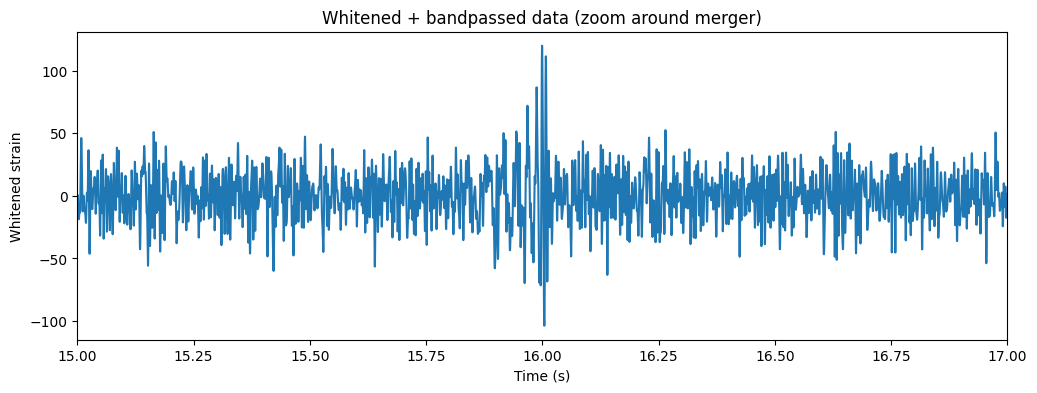

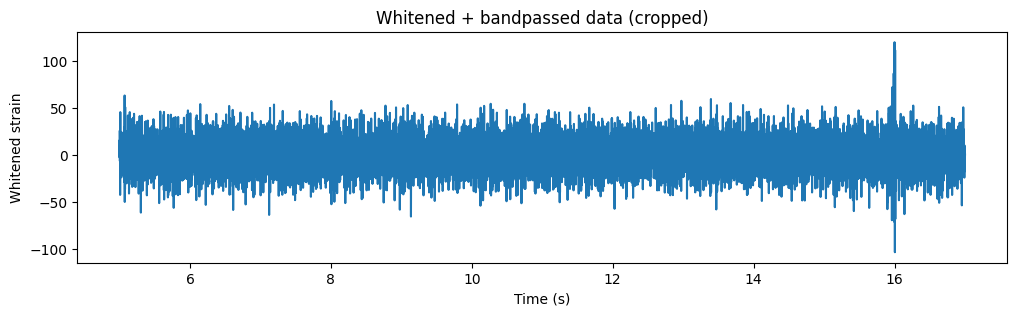

In [43]:
f_high_cut = 300.0 # as used in the previous tutorial
segment_duration = 4.0 # s from the segment we took for the PSD
max_filter_duration = 4.0  # s because 4 * sample_rate samples = 4 seconds

# we take the data to the freuqency domain since we whiten it there
data_fs = data.to_frequencyseries()

# There was an announcement that we always whiten the data in the
# frequency domain, but the whiten function works in the time domain and since it is the
# function that we worked with in the previous tutorial I assumed we were to use it insetead of
# other method that works on the frequency domain
white = data.whiten(segment_duration=segment_duration, max_filter_duration=max_filter_duration, low_frequency_cutoff=f_low_cut)

# we now bandpass the cropped data
white_bp = white.highpass_fir(f_low_cut, 512)
white_bp = white_bp.lowpass_fir(f_high_cut, 512)


# We crop 5 seconds at the beginning and end of the data. However, since the instructions
# specified that the GW signal should be injected at 5 seconds, I adjusted the setup so
# that the signal starts at that point, with its peak occurring around 16 seconds.
# For this reason, I cropped the data up to 17 seconds in order to clearly capture
# the signal peak.
# I was unsure about the intended approach, because placing the peak at 5 seconds would
# mean that the 4-second segment used for the PSD estimation would not contain only noise.
# Since I worked on this quite late, I did not have the opportunity to ask for clarification.
# I apologize for any confusion this may cause, and I hope that this explanation clarifies
# my reasoning behind the choices made here.

white_c_bp = white_bp.time_slice(5, 17)

# this plot let us zoom around injection at ~16 s
plt.figure(figsize=(12,4))
plt.plot(white_c_bp.sample_times, white_c_bp)
plt.axvline(5.0, ls="--", alpha=0.7)
plt.xlim(15.0, 17.0)
plt.xlabel("Time (s)")
plt.ylabel("Whitened strain")
plt.title("Whitened + bandpassed data (zoom around merger)")
plt.show()

# and this is the fully cropped segment
plt.figure(figsize=(12,3))
plt.plot(white_c_bp.sample_times, white_c_bp)
plt.xlabel("Time (s)")
plt.ylabel("Whitened strain")
plt.title("Whitened + bandpassed data (cropped)")
plt.show()

# as expected the noise is basically stationary and we see a clear peak at 16s where we inserted the signal's peak to be

Good job arriving at the end of the tutorial! This was a small peak at GW data analysis that I hope you found interesting.

There is a bonus track exercise if you are bored, but we can also have a chat about some more GW data analysis if you prefer.